In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklego.preprocessing import RepeatingBasisFunction

In [29]:
df = pd.read_csv('../data/train.csv')

df["date"] = pd.to_datetime(df["date"])
df = df.groupby("date")["sales"].mean().reset_index()

In [84]:
results_df = df.copy().set_index("date")
results_df.columns = ["actuals"]
results_df.head()

,actuals
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


<Figure size 1600x400 with 0 Axes>

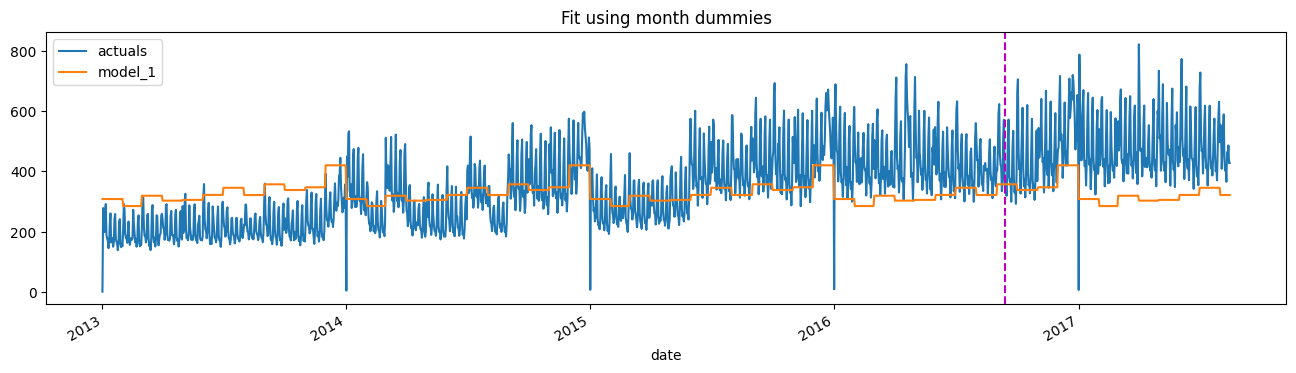

In [104]:
X_1 = pd.get_dummies(df["date"].dt.month, drop_first=True, prefix="month")
X_1.index = df["date"]

# Target (sales)
y = df["sales"]
# Define train-test split
TRAIN_END = int(0.8 * len(df))  # Use 80% for training
end_training_date = results_df.index[TRAIN_END]

# Fit a linear regression model
model_1 = LinearRegression().fit(X_1.iloc[:TRAIN_END], y.iloc[:TRAIN_END])

# Store the predictions in a results DataFrame
results_df["model_1"] = model_1.predict(X_1)

# Plot the actual vs predicted values
plt.figure(figsize=(16, 4))

results_df[["actuals", "model_1"]].plot(figsize=(16,4),
                                    	title="Fit using month dummies")
plt.axvline(end_training_date, c="m", linestyle="--")
plt.show()


In [32]:
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

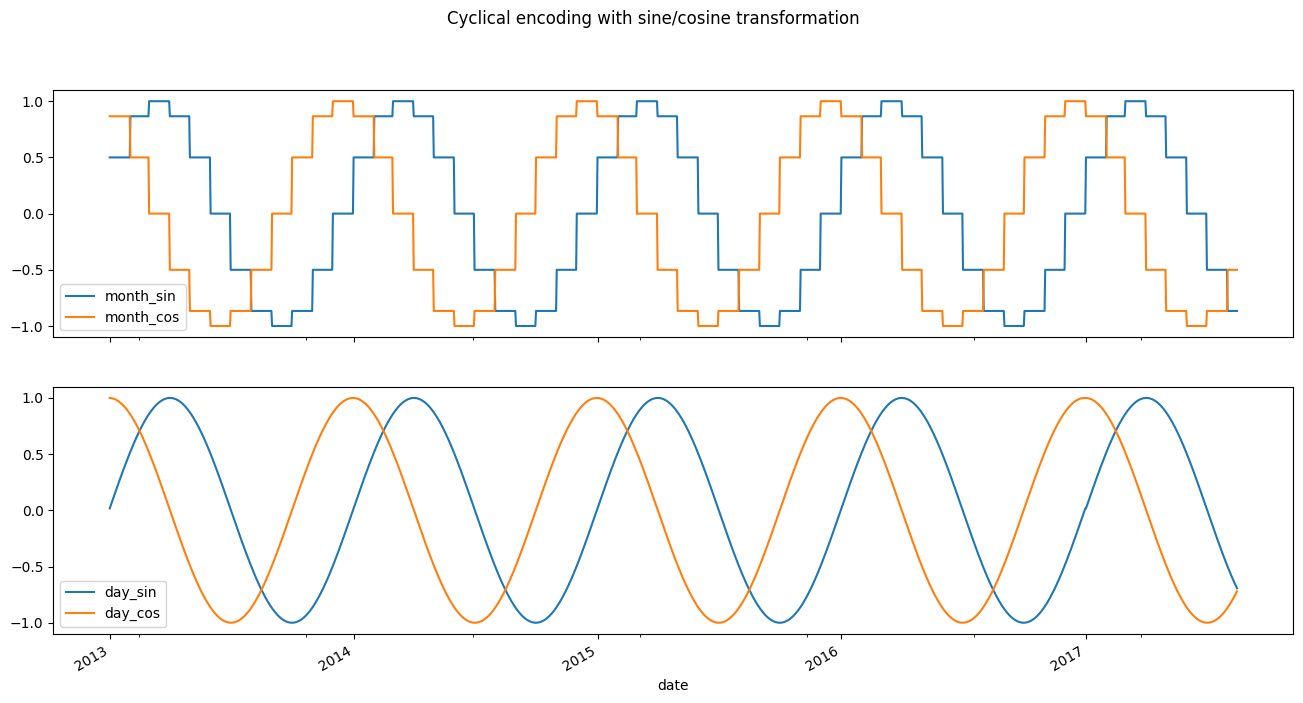

In [88]:
X_2 = X.copy()
X_2["month"] = X_2.index.month

X_2["month_sin"] = sin_transformer(12).fit_transform(X_2)["month"]
X_2["month_cos"] = cos_transformer(12).fit_transform(X_2)["month"]

X_2["day_sin"] = sin_transformer(365).fit_transform(X_2)["day_of_year"]
X_2["day_cos"] = cos_transformer(365).fit_transform(X_2)["day_of_year"]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16,8))
X_2[["month_sin", "month_cos"]].plot(ax=ax[0])
X_2[["day_sin", "day_cos"]].plot(ax=ax[1])
plt.suptitle("Cyclical encoding with sine/cosine transformation");

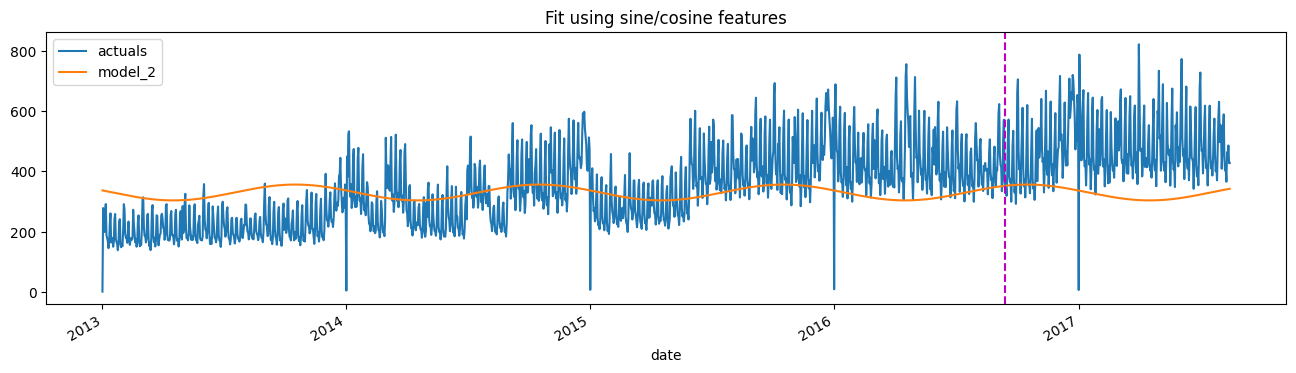

In [105]:
X_2_daily = X_2[["day_sin", "day_cos"]]

model_2 = LinearRegression().fit(X_2_daily.iloc[:TRAIN_END],
                             	y.iloc[:TRAIN_END])

results_df["model_2"] = model_2.predict(X_2_daily)
results_df[["actuals", "model_2"]].plot(figsize=(16,4),
                                    	title="Fit using sine/cosine features")
plt.axvline(end_training_date, c="m", linestyle="--")

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

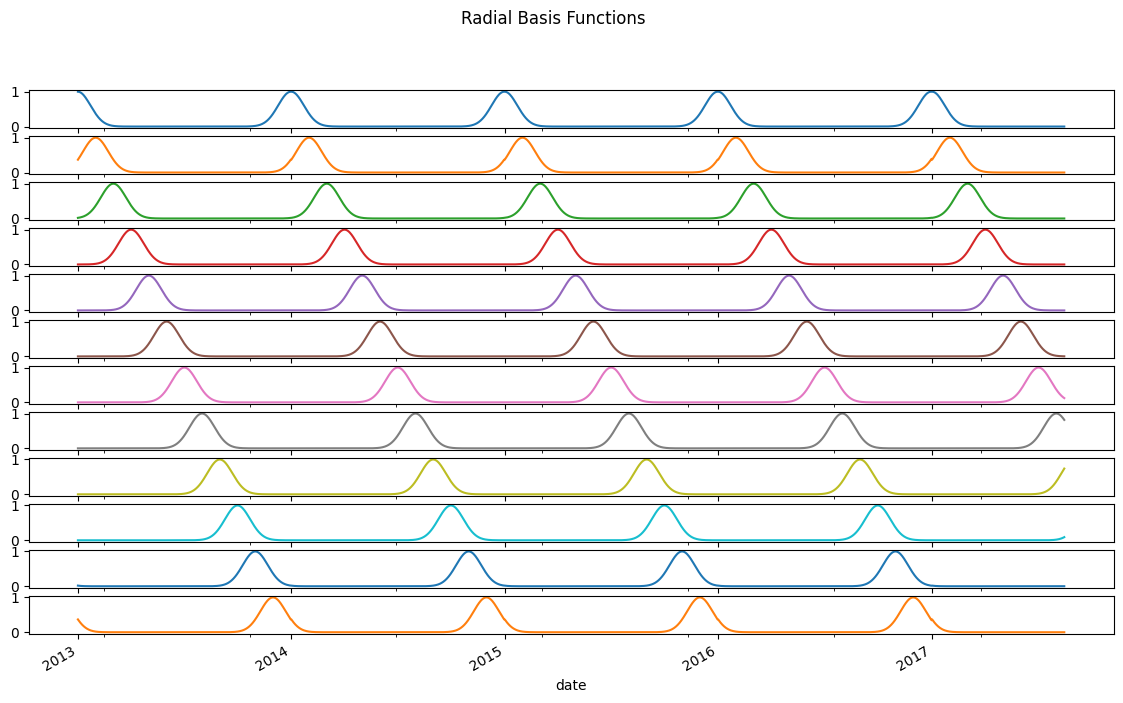

In [92]:
range_of_dates = df["date"]
X = pd.DataFrame(index=range_of_dates)
# create a sequence of day numbers
X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.day_of_year

rbf = RepeatingBasisFunction(n_periods=12,
                         	column="day_of_year",
                         	input_range=(1,365),
                         	remainder="drop")
rbf.fit(X)
X_3 = pd.DataFrame(index=X.index,
               	data=rbf.transform(X))

X_3.plot(subplots=True, figsize=(14, 8),
     	sharex=True, title="Radial Basis Functions",
     	legend=False)

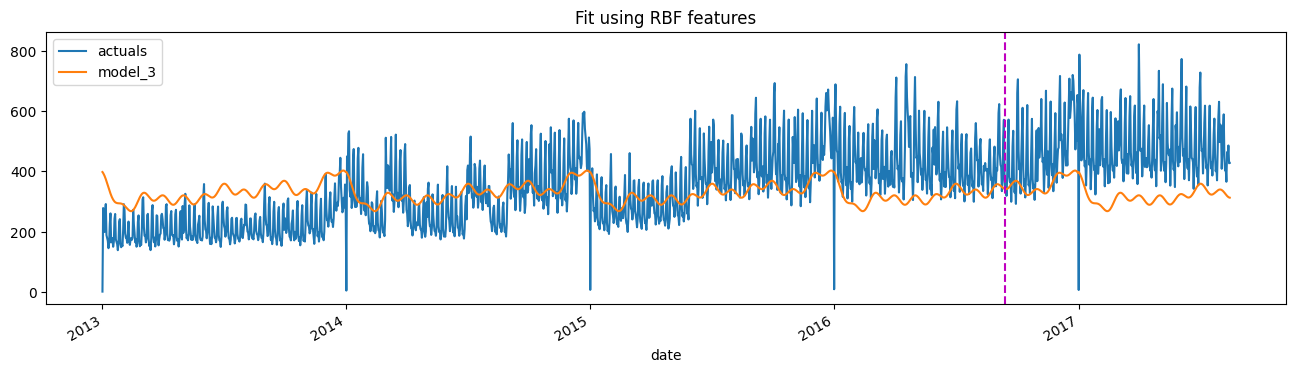

In [106]:
model_3 = LinearRegression().fit(X_3.iloc[:TRAIN_END],
                             	y.iloc[:TRAIN_END])

results_df["model_3"] = model_3.predict(X_3)
results_df[["actuals", "model_3"]].plot(figsize=(16,4),
                                    	title="Fit using RBF features")

plt.axvline(end_training_date, c="m", linestyle="--")

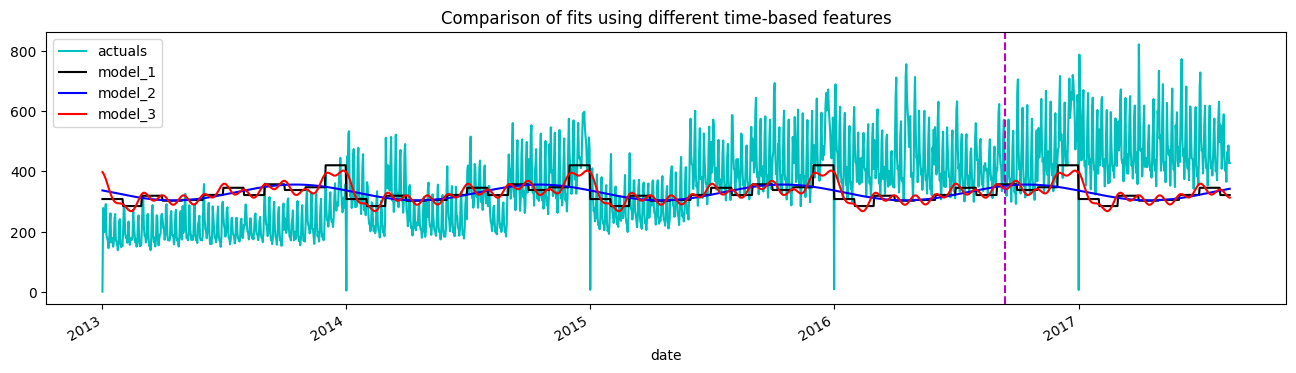

In [107]:
results_df.plot(title="Comparison of fits using different time-based features",
            	figsize=(16,4),
            	color = ["c", "k", "b", "r"])

plt.axvline(end_training_date, c="m", linestyle="--")

In [96]:
score_list = []
for fit_col in ["model_1", "model_2", "model_3"]:
	scores = {
    	"model": fit_col,
    	"train_score": mean_absolute_error(
        	results_df.iloc[:TRAIN_END]["actuals"],
        	results_df.iloc[:TRAIN_END][fit_col]
    	),
    	"test_score": mean_absolute_error(
        	results_df.iloc[TRAIN_END:]["actuals"],
        	results_df.iloc[TRAIN_END:][fit_col]
    	)
	}
	score_list.append(scores)

scores_df = pd.DataFrame(score_list)
scores_df

,model,train_score,test_score
0,model_1,93.682638,149.030356
1,model_2,96.612911,151.687388
2,model_3,93.863093,150.438633
